# 导包

In [1]:
import torch
import torchvision
import torch.nn
import torch.nn.init
import torch.utils.data as data
print(torch.__version__)
print(torchvision.__version__)
print(torch.cuda.is_available())
import matplotlib.pyplot as plt
from IPython import display
import numpy as np
import random

1.4.0
0.5.0
True


In [2]:
import basic
import data

# 过拟合、欠拟合
## 基本概念
- 欠拟合：模型无法得到较低的训练误差；
- 过拟合：模型在训练集上的误差远小于其在测试数据集的误差；

### 数据集划分
- 训练集：用于模型自主学习其参数
- 验证集：用于模型选择
- 测试集

训练数据不够时，可用K折交叉验证。

### 半对数作图工具函数

In [3]:
def semilogy(x_vals, y_vals, x_label, y_label, x2_vals=None, y2_vals=None, legend=None, figsize=(3.5, 2.5)):
    """
    x_vals, y_vals, x_label, y_labe可迭代。
    """
    plt.rcParams["figure.figsize"] = figsize
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
        plt.legend(legend)

## 过拟合、欠拟合的影响因素
1. 模型复杂程度
2. 训练数据集大小

In [4]:
num_epochs = 10 # 此处应设为100

In [5]:
def fit_and_plot(train_features, test_features, train_labels, test_labels):
    dataset = torch.utils.data.TensorDataset(train_features, train_labels)      
    batch_size = min(10, train_labels.shape[0])    
    train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True, num_workers=4) 
    
    net = torch.nn.Linear(train_features.shape[-1], 1)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.01)
    
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:                                                
            l = loss(net(X), y.view(-1, 1))   # sum可加可不加
            optimizer.zero_grad()                                          
            l.backward()                                                    
            optimizer.step()                
            
        train_labels = train_labels.view(-1, 1)
        test_labels = test_labels.view(-1, 1)
        train_ls.append(loss(net(train_features), train_labels).item())        
        test_ls.append(loss(net(test_features), test_labels).item())          
    print('final epoch: train loss', train_ls[-1], 'test loss', test_ls[-1])    
    semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('weight:', net.weight.data, '\nbias:', net.bias.data)

### 多项式函数拟合实验
$$y = 1.2x - 3.4x^2 + 5.6x^3 + 5 + \epsilon,$$

In [6]:
n_train, n_test, true_w, true_b = 100, 100, [1.2, -3.4, 5.6], 5
features = torch.randn((n_train + n_test, 1))

In [7]:
poly_features = torch.cat((features, torch.pow(features, 2), torch.pow(features, 3)), 1) 
poly_features.shape

torch.Size([200, 3])

In [8]:
labels = (true_w[0] * poly_features[:, 0] + true_w[1] * poly_features[:, 1] + true_w[2] * poly_features[:, 2] + true_b)
labels.shape

torch.Size([200])

### 模型复杂度

final epoch: train loss 2.7304091453552246 test loss 3.825640916824341
weight: tensor([[ 1.6165, -2.2330,  5.2208]]) 
bias: tensor([2.9346])


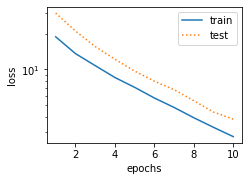

In [9]:
fit_and_plot(poly_features[:n_train, :], poly_features[n_train:, :], labels[:n_train], labels[n_train:])

final epoch: train loss 112.85729217529297 test loss 211.14013671875
weight: tensor([[13.8704]]) 
bias: tensor([3.6471])


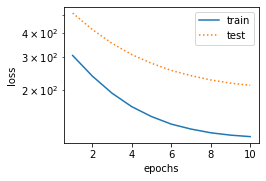

In [10]:
fit_and_plot(features[:n_train, :], features[n_train:, :], labels[:n_train], labels[n_train:])

### 训练样本数据量

final epoch: train loss 15.11817455291748 test loss 453.8798522949219
weight: tensor([[0.0727, 0.4409, 0.6977]]) 
bias: tensor([1.3452])


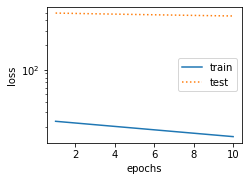

In [11]:
fit_and_plot(poly_features[0:2, :], poly_features[n_train:, :], labels[0:2], labels[n_train:])

## 过拟合的解决方案

过拟合的解决方案对应的是训练过程，即优化器。
- 权重衰减法修改的是损失函数
- 丢弃法等效给每个隐藏层的输出增加一个遗忘层


### L2正则化（权重衰减）

$$\ell(w_1, w_2, b) + \frac{\lambda}{2n} |\boldsymbol{w}|^2,$$
$$
\begin{aligned} w_1 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_1 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_1^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right),\\ w_2 &\leftarrow \left(1- \frac{\eta\lambda}{|\mathcal{B}|} \right)w_2 - \frac{\eta}{|\mathcal{B}|} \sum_{i \in \mathcal{B}}x_2^{(i)} \left(x_1^{(i)} w_1 + x_2^{(i)} w_2 + b - y^{(i)}\right). \end{aligned}
$$

#### 数据准备：高维线性回归实验

$$y = 0.05 + \sum_{i = 1}^p 0.01x_i + \epsilon ,\\
p=200$$

In [12]:
n_train, n_test, num_inputs = 20, 100, 200
true_w, true_b = torch.ones(num_inputs, 1) * 0.01, 0.05

In [13]:
features = torch.randn((n_train + n_test, num_inputs))
features.shape

torch.Size([120, 200])

In [14]:
labels = torch.matmul(features, true_w) + true_b
labels += torch.tensor(np.random.normal(0, 0.01, size=labels.size()), dtype=torch.float)
labels.shape

torch.Size([120, 1])

In [15]:
train_features, test_features = features[:n_train, :], features[n_train:, :]
train_labels, test_labels = labels[:n_train], labels[n_train:]

In [16]:
def init_params():
    w = torch.randn((num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad=True)
    return [w, b]

In [17]:
batch_size = 1
dataset = torch.utils.data.TensorDataset(train_features, train_labels)
train_iter = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)

In [18]:
num_epochs, lr = 100, 0.003

#### L2惩罚项

In [19]:
def l2_penalty(w):
    """
    计算模型的l2惩罚项。
    
    :param w:模型的权重；
    :return: 模型的L2惩罚项，tensor.shape=(1,)；
    """
    return (w**2).sum() / 2

#### 训练

In [20]:
net = basic.linreg
loss = basic.squared_loss

In [21]:
def fit_and_plot(lambd):
    w, b = init_params()
    train_ls, test_ls = [], []
    for _ in range(num_epochs):
        for X, y in train_iter:
            l = loss(net(X, w, b), y) + lambd * l2_penalty(w)    # 每个示例的损失
            l = l.sum()
            
            if w.grad is not None:
                w.grad.data.zero_()
                b.grad.data.zero_()
            l.backward()
            basic.sgd([w, b], lr, batch_size)
            
        train_ls.append(loss(net(train_features, w, b), train_labels).mean().item())
        test_ls.append(loss(net(test_features, w, b), test_labels).mean().item())
    basic.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', 
                   range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', w.norm().item())

L2 norm of w: 13.634110450744629
L2 norm of w: 0.04016406089067459


Text(0.5, 1.0, 'With L2')

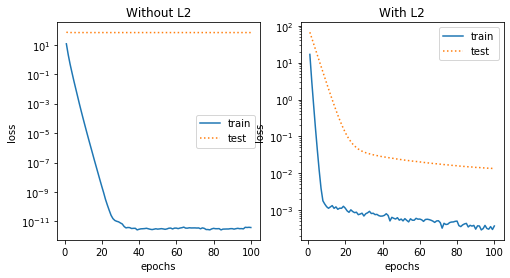

In [22]:
plt.figure(figsize=(8,4))
plt.subplot(121)
fit_and_plot(lambd=0)
plt.title("Without L2")
plt.subplot(122)
fit_and_plot(lambd=3)
plt.title("With L2")

#### 简洁实现

In [23]:
def fit_and_plot(wd):
    net = torch.nn.Linear(num_inputs, 1)
    torch.nn.init.normal(net.weight, mean=0, std=1)
    torch.nn.init.normal(net.bias, mean=0, std=1)
    optimizer_w = torch.optim.SGD(params=[net.weight], lr=lr, weight_decay=wd)
    optimizer_b = torch.optim.SGD(params=[net.bias], lr=lr)
    
    train_ls, test_ls = [],[]
    for _ in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X),y).mean()
            optimizer_w.zero_grad()
            optimizer_b.zero_grad()
            l.backward()
            optimizer_w.step()
            optimizer_b.step()
        train_ls.append(loss(net(train_features), train_labels).mean().item())
        test_ls.append(loss(net(test_features), test_labels).mean().item())
    basic.semilogy(range(1, num_epochs + 1), train_ls, 'epochs', 'loss', range(1, num_epochs + 1), test_ls, ['train', 'test'])
    print('L2 norm of w:', net.weight.data.norm().item())    

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: nn.init.normal is now deprecated in favor of nn.init.normal_.
  after removing the cwd from sys.path.


L2 norm of w: 13.732386589050293
L2 norm of w: 0.03447576239705086


Text(0.5, 1.0, 'With L2')

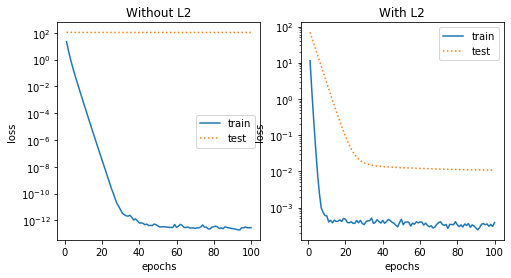

In [24]:
plt.figure(figsize=(8,4))
plt.subplot(121)
fit_and_plot(wd=0)
plt.title("Without L2")
plt.subplot(122)
fit_and_plot(wd=3)
plt.title("With L2")

### 丢弃法
只在训练的时候丢弃，预测的时候不丢弃。丢弃完后，未丢弃的输出要增大。
$$E(h_i') = \frac{E(\xi_i)}{1-p}h_i = h_i$$

#### 数据准备：2个隐藏层

In [25]:
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

In [26]:
W1 = torch.tensor(np.random.normal(0, 0.01, size=(num_inputs, num_hiddens1)), dtype=torch.float, requires_grad=True)
b1 = torch.zeros(num_hiddens1, requires_grad=True)
W2 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens1, num_hiddens2)), dtype=torch.float, requires_grad=True)
b2 = torch.zeros(num_hiddens2, requires_grad=True)
W3 = torch.tensor(np.random.normal(0, 0.01, size=(num_hiddens2, num_outputs)), dtype=torch.float, requires_grad=True)
b3 = torch.zeros(num_outputs, requires_grad=True)
params = [W1, b1, W2, b2, W3, b3]

In [27]:
num_epochs, lr, batch_size = 5, 100.0, 256

In [28]:
train_iter = torch.utils.data.DataLoader(data.mnist_train, batch_size=batch_size, shuffle=True, num_workers=4)
test_iter = torch.utils.data.DataLoader(data.mnist_test, batch_size=batch_size, shuffle=False, num_workers=4)

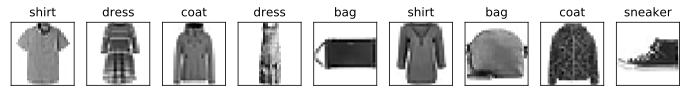

In [29]:
for X,y in train_iter:
    break
true_labels = data.get_fashion_mnist_labels(y.numpy())
titles = [lb for lb in true_labels]
data.show_fashion_mnist(X[0:9], titles[0:9])

#### dropout
仅随机遗忘隐藏层的输出，对输出层的输出无效。

In [30]:
def dropout(X, drop_prob):
    X = X.float()
    assert 0 <= drop_prob <= 1
    keep_prob = 1 - drop_prob
    if keep_prob == 0:
        return torch.zeros_like(X)
    mask = (torch.rand(X.shape) < keep_prob).float()
    return mask * X / keep_prob

#### 训练

In [31]:
drop_prob1, drop_prob2 = 0.2, 0.5

In [32]:
loss = torch.nn.CrossEntropyLoss()

In [33]:
def net(X, is_training=True):
    X = X.view(-1, num_inputs)
    H1 = (torch.matmul(X, W1) + b1).relu()
    if is_training: 
        H1 = dropout(H1, drop_prob1) 
    H2 = (torch.matmul(H1, W2) + b2).relu()
    if is_training:
        H2 = dropout(H2, drop_prob2) 
    return torch.matmul(H2, W3) + b3

In [34]:
basic.train_ch3(net,train_iter,test_iter,loss,num_epochs,batch_size, params, lr)

epoch 1, loss 0.0045, train acc 0.557, test acc 0.768
epoch 2, loss 0.0023, train acc 0.787, test acc 0.830
epoch 3, loss 0.0019, train acc 0.822, test acc 0.835
epoch 4, loss 0.0017, train acc 0.840, test acc 0.809
epoch 5, loss 0.0016, train acc 0.848, test acc 0.843


#### 简洁实现

In [35]:
net = torch.nn.Sequential(
        basic.FlattenLayer(),
        torch.nn.Linear(num_inputs, num_hiddens1),
        torch.nn.ReLU(),
        torch.nn.Dropout(drop_prob1),
        torch.nn.Linear(num_hiddens1, num_hiddens2), 
        torch.nn.ReLU(),
        torch.nn.Dropout(drop_prob2),
        torch.nn.Linear(num_hiddens2, 10)
        )

In [36]:
for param in net.parameters():
    torch.nn.init.normal_(param, mean=0, std=0.01)

In [37]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr=0.5)

In [38]:
basic.train_ch3(net, train_iter, test_iter, loss, num_epochs, batch_size, None, None, optimizer)

epoch 1, loss 0.0048, train acc 0.540, test acc 0.696
epoch 2, loss 0.0025, train acc 0.762, test acc 0.815
epoch 3, loss 0.0020, train acc 0.814, test acc 0.796
epoch 4, loss 0.0018, train acc 0.832, test acc 0.815
epoch 5, loss 0.0017, train acc 0.842, test acc 0.813


## 欠拟合的解决方案
[参考资料](https://www.boyuai.com/elites/course/FFR7c6pCPEkHJCcY/video/ZQ2Kk3DkN9lVX2z5kFm1C)

### 激活函数ReLu
在输入x>0的时候始终有梯度(1), 因为梯度为常数，所以计算速度很快。

那么为什么当x<0的时候梯度为0，就不认为是梯度消失问题呢？可能是这个被当成是使神经网络能够稀疏表示的特性。被disable的神经元输出值为0，和w就无关了。这和w很难被更新是两个问题。（缺预训练的介绍）。

### 批标准化
batch过sigmoid之前先弄成正态分布。这就带来两个问题：
1. 标准差可能为0，使得映射过程分母为0, 所以引入一个微小正数而不是直接除以标准差。
2. 这样强行的转换相当于定义了这个正态分布的样子：N(0,1)，这个不合理(参考问题)，所以用gamma和beta来平移和放缩这个分布。

### 残差网络
当网络层数变多的时候，发现，很难训练（很可能是因为梯度消失）。深度残差网络既能加深网络，又能保证网络的性能。其方式就是在原来的层上多加一层，再把输入值加回去。本质上是把学习x到y的网络变成学习x到y-x的网络，学习的是从浅层到深层的”变化“。这里我的理解是把y和x的共性部分去掉后看看不一样的部分差多大。对于图像直观意义上比如背景色不同的同样图片，残差就是背景色差值i guess。

# 模型稳定性
模型层数比较多的时候，出现梯度消失或者梯度爆炸。

## 初始化模型参数的原因
如果将每个隐藏单元的参数都初始化为相等的值，那么在正向传播时每个隐藏单元将根据相同的输入计算出相同的值，并传递至输出层。在反向传播中，每个隐藏单元的参数梯度值相等。因此，这些参数在使用基于梯度的优化算法迭代后值依然相等。之后的迭代也是如此。在这种情况下，无论隐藏单元有多少，隐藏层本质上只有1个隐藏单元在发挥作用。

## Xavier随机初始化
$$U\left(-\sqrt{\frac{6}{a+b}}, \sqrt{\frac{6}{a+b}}\right).$$

它的设计主要考虑到，模型参数初始化后，每层输出的方差不该受该层输入个数影响，且每层梯度的方差也不该受该层输出个数影响。

## 环境因素
### 协变量偏移
训练集和测试集的分布不同。

- 特征分布随时间而改变，但是标记函数，即条件分布P（y∣x）不会改变。
- 在一个看起来与测试集有着本质不同的数据集上进行训练，而不考虑如何适应新的情况。

### 标签偏移
训练集出现了测试集没有的标签。

- 有时标签偏移和协变量移位假设可以同时成立。
- 导致偏移的是标签P（y）上的边缘分布的变化，但类条件分布是不变的P（x∣y）时，就会出现与协变量偏移相反的问题。

### 概念偏移
标签本身的定义发生变化的情况。